<a href="https://colab.research.google.com/github/PETEROA/ML-Optimization-Daily/blob/main/Depthwise_convul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook looks into Efficient Architectures by exploring depthwise separable convolutions—the fundamental building block that enabled mobile-scale deep learning. Standard convolutions are computationally expensive: a 3×3 conv on 256 channels requires 256×256×3×3 = 590K parameters per output position. Depthwise separable convolutions factor this into two steps: a depthwise convolution (one filter per input channel) followed by a pointwise 1×1 convolution (mixing channels). This reduces parameters and FLOPs by 8-9× with minimal accuracy loss. I implement both operations from scratch, analyze the computational savings mathematically, build the inverted residual block (MobileNetV2's core), and experimentally compare against standard convolutions. Understanding depthwise separable convolutions is essential—they're used in MobileNet, EfficientNet, MixNet, and countless production models.


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List, Dict, Tuple, Union
from dataclasses import dataclass
from copy import deepcopy
import time
import warnings

In [17]:
def compute_conv_stats(c_in: int, c_out: int, kernel_size: int,
                       h: int, w: int) -> Dict[str, Dict]:
    """
    Compute parameter and FLOP counts for standard vs separable conv.
    """
    k = kernel_size

    # Standard convolution
    std_params = c_in * c_out * k * k
    std_flops = h * w * c_in * c_out * k * k * 2  # multiply-add = 2 ops

    # Depthwise separable
    dw_params = c_in * k * k
    pw_params = c_in * c_out
    sep_params = dw_params + pw_params

    dw_flops = h * w * c_in * k * k * 2
    pw_flops = h * w * c_in * c_out * 2
    sep_flops = dw_flops + pw_flops

    return {
        'standard': {
            'params': std_params,
            'flops': std_flops
        },
        'separable': {
            'params': sep_params,
            'flops': sep_flops,
            'dw_params': dw_params,
            'pw_params': pw_params
        },
        'reduction': {
            'params': std_params / sep_params,
            'flops': std_flops / sep_flops
        }
    }


# Example calculations
print("Computational Comparison (3×3 conv, 256→256 channels, 32×32 input)")
print("=" * 65)

stats = compute_conv_stats(256, 256, 3, 32, 32)

print(f"\nStandard Convolution:")
print(f"  Parameters: {stats['standard']['params']:,}")
print(f"  FLOPs: {stats['standard']['flops']:,}")

print(f"\nDepthwise Separable:")
print(f"  Depthwise params: {stats['separable']['dw_params']:,}")
print(f"  Pointwise params: {stats['separable']['pw_params']:,}")
print(f"  Total params: {stats['separable']['params']:,}")
print(f"  Total FLOPs: {stats['separable']['flops']:,}")

print(f"\nReduction:")
print(f"  Parameters: {stats['reduction']['params']:.1f}× fewer")
print(f"  FLOPs: {stats['reduction']['flops']:.1f}× fewer")

Computational Comparison (3×3 conv, 256→256 channels, 32×32 input)

Standard Convolution:
  Parameters: 589,824
  FLOPs: 1,207,959,552

Depthwise Separable:
  Depthwise params: 2,304
  Pointwise params: 65,536
  Total params: 67,840
  Total FLOPs: 138,936,320

Reduction:
  Parameters: 8.7× fewer
  FLOPs: 8.7× fewer


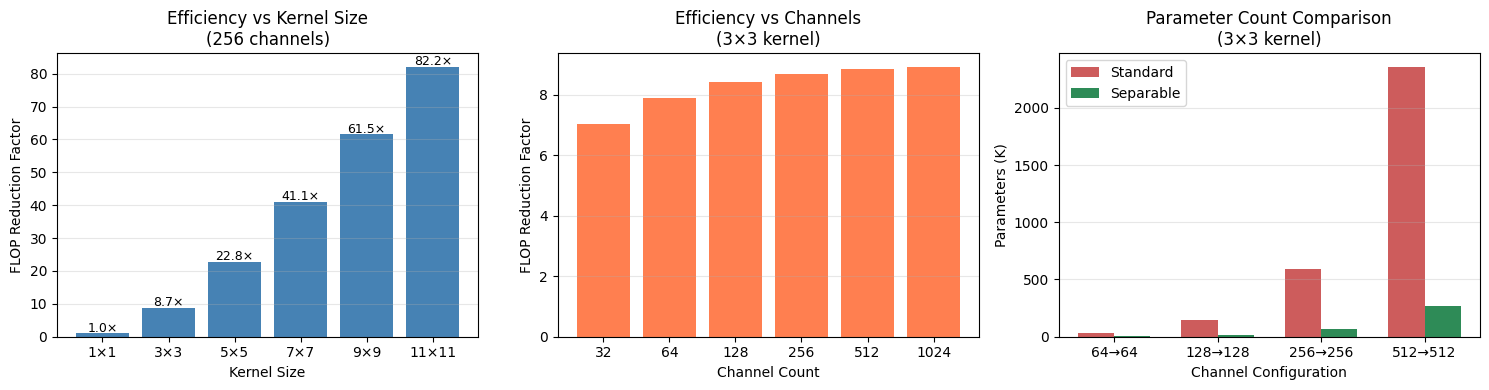

In [18]:
# Visualize efficiency across different configurations

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Reduction vs kernel size
ax = axes[0]
kernels = [1, 3, 5, 7, 9, 11]
reductions = [compute_conv_stats(256, 256, k, 32, 32)['reduction']['flops'] for k in kernels]
ax.bar(range(len(kernels)), reductions, color='steelblue')
ax.set_xticks(range(len(kernels)))
ax.set_xticklabels([f'{k}×{k}' for k in kernels])
ax.set_xlabel('Kernel Size')
ax.set_ylabel('FLOP Reduction Factor')
ax.set_title('Efficiency vs Kernel Size\n(256 channels)')
ax.grid(True, alpha=0.3, axis='y')
for i, r in enumerate(reductions):
    ax.text(i, r + 0.5, f'{r:.1f}×', ha='center', fontsize=9)

# Plot 2: Reduction vs channel count
ax = axes[1]
channels = [32, 64, 128, 256, 512, 1024]
reductions = [compute_conv_stats(c, c, 3, 32, 32)['reduction']['flops'] for c in channels]
ax.bar(range(len(channels)), reductions, color='coral')
ax.set_xticks(range(len(channels)))
ax.set_xticklabels(channels)
ax.set_xlabel('Channel Count')
ax.set_ylabel('FLOP Reduction Factor')
ax.set_title('Efficiency vs Channels\n(3×3 kernel)')
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Parameter breakdown
ax = axes[2]
configs = [(64, 64), (128, 128), (256, 256), (512, 512)]
x = np.arange(len(configs))
width = 0.35

std_params = [compute_conv_stats(c[0], c[1], 3, 1, 1)['standard']['params'] / 1000 for c in configs]
sep_params = [compute_conv_stats(c[0], c[1], 3, 1, 1)['separable']['params'] / 1000 for c in configs]

ax.bar(x - width/2, std_params, width, label='Standard', color='indianred')
ax.bar(x + width/2, sep_params, width, label='Separable', color='seagreen')
ax.set_xticks(x)
ax.set_xticklabels([f'{c[0]}→{c[1]}' for c in configs])
ax.set_xlabel('Channel Configuration')
ax.set_ylabel('Parameters (K)')
ax.set_title('Parameter Count Comparison\n(3×3 kernel)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('separable_conv_efficiency.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
class DepthwiseConv2d(nn.Module):
    """
    Depthwise Convolution: applies separate K×K filter to each input channel.

    This is implemented using groups=in_channels in PyTorch's Conv2d.
    Each input channel gets its own filter, no cross-channel interaction.

    Parameters: in_channels × kernel_size × kernel_size
    """

    def __init__(
        self,
        in_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: int = 1,
        bias: bool = False
    ):
        super().__init__()

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,  # Same as input
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_channels,  # Key: each channel gets own filter
            bias=bias
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class PointwiseConv2d(nn.Module):
    """
    Pointwise Convolution: 1×1 convolution for channel mixing.

    No spatial filtering, only combines channels at each position.

    Parameters: in_channels × out_channels
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        bias: bool = False
    ):
        super().__init__()

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=bias
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)

In [20]:
class DepthwiseSeparableConv2d(nn.Module):


    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: int = 1,
        bias: bool = False,
        norm: str = 'bn',
        activation: str = 'relu'
    ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

        # Depthwise
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size,
            stride=stride, padding=padding, groups=in_channels, bias=bias
        )

        # Pointwise
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, 1,
            stride=1, padding=0, bias=bias
        )

        # Normalization
        self.bn_dw = nn.BatchNorm2d(in_channels) if norm == 'bn' else nn.Identity()
        self.bn_pw = nn.BatchNorm2d(out_channels) if norm == 'bn' else nn.Identity()

        # Activation
        if activation == 'relu':
            self.act = nn.ReLU(inplace=True)
        elif activation == 'relu6':
            self.act = nn.ReLU6(inplace=True)
        elif activation == 'swish' or activation == 'silu':
            self.act = nn.SiLU(inplace=True)
        else:
            self.act = nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Depthwise
        x = self.depthwise(x)
        x = self.bn_dw(x)
        x = self.act(x)

        # Pointwise
        x = self.pointwise(x)
        x = self.bn_pw(x)
        x = self.act(x)

        return x

    @property
    def num_params(self) -> int:
        return sum(p.numel() for p in self.parameters())

    def extra_repr(self) -> str:
        return (f'{self.in_channels}, {self.out_channels}, '
                f'kernel_size={self.kernel_size}, stride={self.stride}')

In [21]:
# Verify implementation

print("Implementation Verification")
print("=" * 50)

# Create layers
std_conv = nn.Conv2d(64, 128, 3, padding=1, bias=False)
sep_conv = DepthwiseSeparableConv2d(64, 128, 3, padding=1, norm='none', activation='none')

# Count parameters
std_params = sum(p.numel() for p in std_conv.parameters())
sep_params = sum(p.numel() for p in sep_conv.parameters())

print(f"\nStandard Conv (64→128, 3×3):")
print(f"  Parameters: {std_params:,}")

print(f"\nSeparable Conv (64→128, 3×3):")
print(f"  Depthwise: {sum(p.numel() for p in sep_conv.depthwise.parameters()):,}")
print(f"  Pointwise: {sum(p.numel() for p in sep_conv.pointwise.parameters()):,}")
print(f"  Total: {sep_params:,}")

print(f"\nReduction: {std_params / sep_params:.1f}×")

# Test forward pass
x = torch.randn(1, 64, 32, 32)
y_std = std_conv(x)
y_sep = sep_conv(x)

print(f"\nOutput shape (standard): {y_std.shape}")
print(f"Output shape (separable): {y_sep.shape}")

Implementation Verification

Standard Conv (64→128, 3×3):
  Parameters: 73,728

Separable Conv (64→128, 3×3):
  Depthwise: 576
  Pointwise: 8,192
  Total: 8,768

Reduction: 8.4×

Output shape (standard): torch.Size([1, 128, 32, 32])
Output shape (separable): torch.Size([1, 128, 32, 32])


Inverted Residual Blocks
MobileNetV2 introduced the **inverted residual block** (also called MBConv):

 *Expand: 1×1 conv to expand channels (e.g., 3-6× expansion)
 *Depthwise: 3×3 depthwise conv in expanded space
 *Project: 1×1 conv to project back to output channels

The "inverted" name comes from the bottleneck structure being opposite to ResNet:
- ResNet: wide → narrow → wide
- MobileNetV2: narrow → wide → narrow

In [22]:
class InvertedResidual(nn.Module):
    """
    Inverted Residual Block (MBConv) from MobileNetV2.

    Structure:
    1. Expand: 1×1 conv (in_channels → expand_channels)
    2. Depthwise: 3×3 depthwise conv
    3. Project: 1×1 conv (expand_channels → out_channels)
    4. Residual connection if stride=1 and in_channels=out_channels

    The expansion happens in a "cheap" high-dimensional space (depthwise),
    while the "expensive" operations (1×1 convs) work in low dimensions.

    Args:
        in_channels: Input channels
        out_channels: Output channels
        stride: Stride for depthwise conv
        expand_ratio: Expansion factor for intermediate channels
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expand_ratio: float = 6.0,
        kernel_size: int = 3
    ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.expand_ratio = expand_ratio

        # Expanded channels
        hidden_dim = int(in_channels * expand_ratio)
        self.hidden_dim = hidden_dim

        # Use residual connection?
        self.use_residual = (stride == 1 and in_channels == out_channels)

        layers = []

        # Expand (skip if expand_ratio == 1)
        if expand_ratio != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True)
            ])

        # Depthwise
        padding = (kernel_size - 1) // 2
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size,
                     stride=stride, padding=padding, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True)
        ])

        # Project (linear - no activation!)
        layers.extend([
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.use_residual:
            return x + self.conv(x)
        else:
            return self.conv(x)

    @property
    def num_params(self) -> int:
        return sum(p.numel() for p in self.parameters())

    def extra_repr(self) -> str:
        return (f'{self.in_channels}→{self.out_channels}, '
                f'expand={self.expand_ratio}, stride={self.stride}, '
                f'residual={self.use_residual}')

In [23]:
class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation block for channel attention.

    Used in EfficientNet's MBConv blocks.

    1. Squeeze: Global average pooling
    2. Excitation: FC → ReLU → FC → Sigmoid
    3. Scale: Element-wise multiplication
    """

    def __init__(self, channels: int, reduction: int = 4):
        super().__init__()

        reduced = max(1, channels // reduction)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, reduced, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(reduced, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, _, _ = x.shape

        # Squeeze
        y = self.pool(x).view(b, c)

        # Excitation
        y = self.fc(y).view(b, c, 1, 1)

        # Scale
        return x * y


class MBConvBlock(nn.Module):
    """
    Mobile Inverted Bottleneck Conv (MBConv) with optional SE.

    This is the building block of EfficientNet.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        expand_ratio: float = 6.0,
        se_ratio: float = 0.25,
        drop_path_rate: float = 0.0
    ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.expand_ratio = expand_ratio
        self.use_residual = (stride == 1 and in_channels == out_channels)

        hidden_dim = int(in_channels * expand_ratio)

        layers = []

        # Expand
        if expand_ratio != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(inplace=True)  # Swish activation
            ])

        # Depthwise
        padding = (kernel_size - 1) // 2
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size,
                     stride=stride, padding=padding, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True)
        ])

        self.conv = nn.Sequential(*layers)

        # SE block
        if se_ratio > 0:
            se_channels = max(1, int(in_channels * se_ratio))
            self.se = SEBlock(hidden_dim, hidden_dim // se_channels)
        else:
            self.se = nn.Identity()

        # Project
        self.project = nn.Sequential(
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # Drop path for stochastic depth
        self.drop_path_rate = drop_path_rate

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        x = self.conv(x)
        x = self.se(x)
        x = self.project(x)

        if self.use_residual:
            if self.training and self.drop_path_rate > 0:
                # Stochastic depth
                if torch.rand(1).item() < self.drop_path_rate:
                    return identity
            return identity + x
        return x

In [24]:
# Compare block types

print("Block Comparison")
print("=" * 60)

# Standard residual block (for reference)
class StandardResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(channels)
        )
    def forward(self, x):
        return x + self.conv(x)

# Create blocks
channels = 64
std_block = StandardResBlock(channels)
inv_res = InvertedResidual(channels, channels, expand_ratio=6)
mbconv = MBConvBlock(channels, channels, expand_ratio=6, se_ratio=0.25)

# Count params
blocks = {
    'Standard Residual': std_block,
    'Inverted Residual (MobileNetV2)': inv_res,
    'MBConv + SE (EfficientNet)': mbconv
}

print(f"\nParameter counts ({channels} channels):")
for name, block in blocks.items():
    params = sum(p.numel() for p in block.parameters())
    print(f"  {name}: {params:,}")

# Test forward
x = torch.randn(1, channels, 32, 32)
print(f"\nOutput shapes:")
for name, block in blocks.items():
    y = block(x)
    print(f"  {name}: {y.shape}")

Block Comparison

Parameter counts (64 channels):
  Standard Residual: 73,984
  Inverted Residual (MobileNetV2): 54,272
  MBConv + SE (EfficientNet): 66,560

Output shapes:
  Standard Residual: torch.Size([1, 64, 32, 32])
  Inverted Residual (MobileNetV2): torch.Size([1, 64, 32, 32])
  MBConv + SE (EfficientNet): torch.Size([1, 64, 32, 32])


Computational Analysis

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def benchmark_layers(in_channels: int, out_channels: int, spatial: int,
                     num_runs: int = 100) -> Dict[str, float]:
    """
    Benchmark different convolution types.
    """
    x = torch.randn(1, in_channels, spatial, spatial).to(device)

    layers = {
        'Standard Conv': nn.Conv2d(in_channels, out_channels, 3, padding=1).to(device),
        'Separable Conv': DepthwiseSeparableConv2d(in_channels, out_channels, 3, padding=1).to(device),
        'Inverted Residual': InvertedResidual(in_channels, out_channels, expand_ratio=6).to(device)
    }

    times = {}

    for name, layer in layers.items():
        layer.eval()

        # Warmup
        for _ in range(10):
            _ = layer(x)

        if device.type == 'cuda':
            torch.cuda.synchronize()

        # Benchmark
        start = time.perf_counter()
        for _ in range(num_runs):
            _ = layer(x)

        if device.type == 'cuda':
            torch.cuda.synchronize()

        elapsed = (time.perf_counter() - start) / num_runs * 1000  # ms
        times[name] = elapsed

    return times


# Benchmark
print("Latency Benchmark")
print("=" * 50)

configs = [
    (32, 64, 56),
    (64, 128, 28),
    (128, 256, 14),
    (256, 512, 7)
]

results = []
for c_in, c_out, spatial in configs:
    times = benchmark_layers(c_in, c_out, spatial)
    results.append((c_in, c_out, spatial, times))

    print(f"\n{c_in}→{c_out}, {spatial}×{spatial}:")
    for name, t in times.items():
        speedup = times['Standard Conv'] / t
        print(f"  {name}: {t:.3f}ms ({speedup:.2f}×)")

Latency Benchmark

32→64, 56×56:
  Standard Conv: 0.087ms (1.00×)
  Separable Conv: 0.353ms (0.25×)
  Inverted Residual: 0.370ms (0.24×)

64→128, 28×28:
  Standard Conv: 0.069ms (1.00×)
  Separable Conv: 0.196ms (0.35×)
  Inverted Residual: 0.375ms (0.18×)

128→256, 14×14:
  Standard Conv: 0.103ms (1.00×)
  Separable Conv: 0.219ms (0.47×)
  Inverted Residual: 0.394ms (0.26×)

256→512, 7×7:
  Standard Conv: 0.176ms (1.00×)
  Separable Conv: 0.215ms (0.82×)
  Inverted Residual: 0.378ms (0.47×)


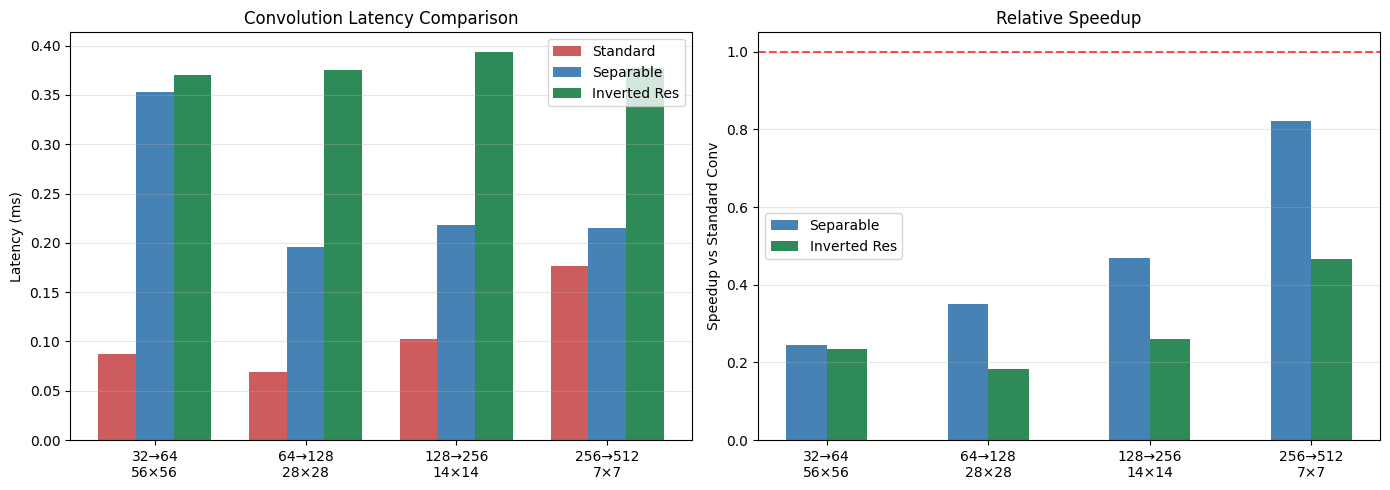

In [26]:
# Visualize benchmark results

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Latency comparison
ax = axes[0]
x_labels = [f"{r[0]}→{r[1]}\n{r[2]}×{r[2]}" for r in results]
x = np.arange(len(x_labels))
width = 0.25

std_times = [r[3]['Standard Conv'] for r in results]
sep_times = [r[3]['Separable Conv'] for r in results]
inv_times = [r[3]['Inverted Residual'] for r in results]

ax.bar(x - width, std_times, width, label='Standard', color='indianred')
ax.bar(x, sep_times, width, label='Separable', color='steelblue')
ax.bar(x + width, inv_times, width, label='Inverted Res', color='seagreen')

ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylabel('Latency (ms)')
ax.set_title('Convolution Latency Comparison')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Speedup
ax = axes[1]
sep_speedup = [r[3]['Standard Conv'] / r[3]['Separable Conv'] for r in results]
inv_speedup = [r[3]['Standard Conv'] / r[3]['Inverted Residual'] for r in results]

ax.bar(x - width/2, sep_speedup, width, label='Separable', color='steelblue')
ax.bar(x + width/2, inv_speedup, width, label='Inverted Res', color='seagreen')

ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylabel('Speedup vs Standard Conv')
ax.set_title('Relative Speedup')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('separable_conv_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

Experimental Comparison

In [27]:
# Build comparable networks

class StandardCNN(nn.Module):
    """CNN with standard convolutions."""

    def __init__(self, num_classes: int = 10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


class SeparableCNN(nn.Module):
    """CNN with depthwise separable convolutions."""

    def __init__(self, num_classes: int = 10):
        super().__init__()

        # First layer is standard (need to go from 1 to more channels)
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.features = nn.Sequential(
            DepthwiseSeparableConv2d(32, 64, 3, padding=1),
            nn.MaxPool2d(2),

            DepthwiseSeparableConv2d(64, 128, 3, padding=1),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


class MobileNetStyle(nn.Module):
    """MobileNet-style network with inverted residuals."""

    def __init__(self, num_classes: int = 10):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        self.features = nn.Sequential(
            InvertedResidual(32, 16, stride=1, expand_ratio=1),
            InvertedResidual(16, 24, stride=2, expand_ratio=6),
            InvertedResidual(24, 24, stride=1, expand_ratio=6),
            InvertedResidual(24, 32, stride=2, expand_ratio=6),
            InvertedResidual(32, 32, stride=1, expand_ratio=6),
            InvertedResidual(32, 64, stride=1, expand_ratio=6),
        )

        self.head = nn.Sequential(
            nn.Conv2d(64, 128, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU6(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.head(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [28]:
# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 632kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.53MB/s]


Train: 60000, Test: 10000


In [29]:
def train_and_evaluate(model, name, epochs=5):
    """Train and evaluate a model."""
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    params = sum(p.numel() for p in model.parameters())
    print(f"\n{name}: {params:,} parameters")

    # Training
    train_times = []
    for epoch in range(epochs):
        model.train()
        start = time.perf_counter()

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            F.cross_entropy(model(data), target).backward()
            optimizer.step()

        train_times.append(time.perf_counter() - start)

        # Evaluate
        model.eval()
        correct = sum(model(d.to(device)).argmax(1).eq(t.to(device)).sum().item()
                     for d, t in test_loader)
        acc = correct / len(test_dataset)
        print(f"  Epoch {epoch+1}: {100*acc:.2f}%, {train_times[-1]:.1f}s")

    # Final evaluation
    model.eval()
    correct = sum(model(d.to(device)).argmax(1).eq(t.to(device)).sum().item()
                 for d, t in test_loader)

    return {
        'params': params,
        'accuracy': correct / len(test_dataset),
        'avg_epoch_time': np.mean(train_times)
    }

In [30]:
# Train all models
print("=" * 60)
print("TRAINING COMPARISON")
print("=" * 60)

models = {
    'Standard CNN': StandardCNN(),
    'Separable CNN': SeparableCNN(),
    'MobileNet-style': MobileNetStyle()
}

results = {}
for name, model in models.items():
    results[name] = train_and_evaluate(model, name, epochs=5)

TRAINING COMPARISON

Standard CNN: 94,410 parameters
  Epoch 1: 95.93%, 13.1s
  Epoch 2: 95.72%, 12.5s
  Epoch 3: 97.47%, 12.4s
  Epoch 4: 97.82%, 13.4s
  Epoch 5: 98.35%, 12.4s

Separable CNN: 13,354 parameters
  Epoch 1: 96.69%, 12.5s
  Epoch 2: 97.85%, 12.5s
  Epoch 3: 98.22%, 12.7s
  Epoch 4: 98.30%, 12.5s
  Epoch 5: 98.49%, 12.6s

MobileNet-style: 70,858 parameters
  Epoch 1: 98.29%, 14.9s
  Epoch 2: 98.24%, 14.9s
  Epoch 3: 98.55%, 14.6s
  Epoch 4: 98.50%, 15.2s
  Epoch 5: 98.63%, 14.7s


In [31]:
# Summary
print("\n" + "=" * 70)
print("RESULTS SUMMARY")
print("=" * 70)

print(f"\n{'Model':<20} {'Params':>12} {'Accuracy':>10} {'Epoch Time':>12} {'Efficiency':>12}")
print("-" * 70)

baseline_params = results['Standard CNN']['params']
for name, r in results.items():
    efficiency = r['accuracy'] / (r['params'] / 1000)  # Acc per K params
    print(f"{name:<20} {r['params']:>12,} {100*r['accuracy']:>9.2f}% {r['avg_epoch_time']:>11.1f}s {efficiency:>11.3f}")


RESULTS SUMMARY

Model                      Params   Accuracy   Epoch Time   Efficiency
----------------------------------------------------------------------
Standard CNN               94,410     98.35%        12.7s       0.010
Separable CNN              13,354     98.49%        12.6s       0.074
MobileNet-style            70,858     98.63%        14.8s       0.014


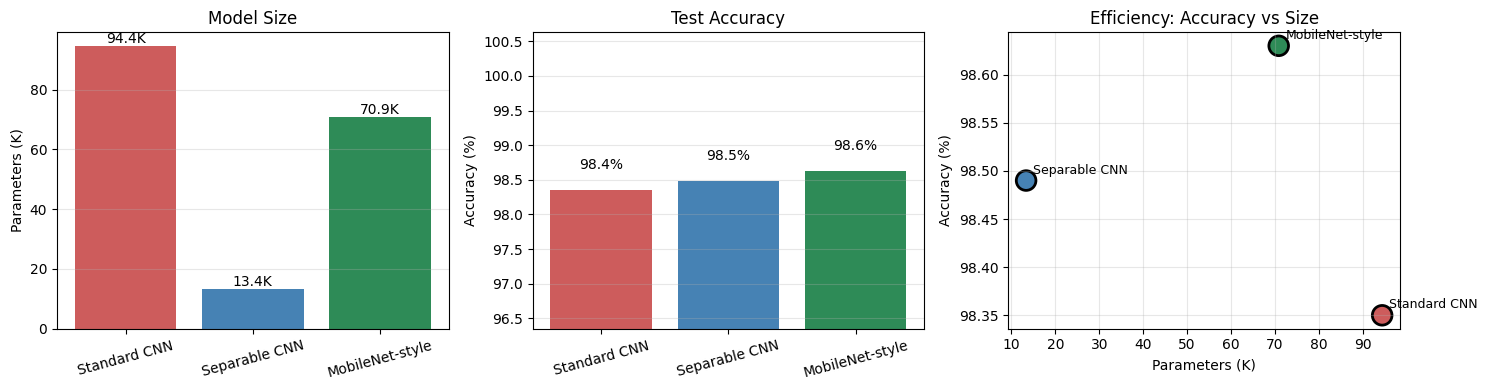

In [32]:
# Final visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

names = list(results.keys())
params = [results[n]['params'] / 1000 for n in names]
accs = [results[n]['accuracy'] * 100 for n in names]
times = [results[n]['avg_epoch_time'] for n in names]

colors = ['indianred', 'steelblue', 'seagreen']

# Plot 1: Parameters
ax = axes[0]
ax.bar(names, params, color=colors)
ax.set_ylabel('Parameters (K)')
ax.set_title('Model Size')
ax.tick_params(axis='x', rotation=15)
for i, (n, p) in enumerate(zip(names, params)):
    ax.text(i, p + 1, f'{p:.1f}K', ha='center', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Accuracy
ax = axes[1]
ax.bar(names, accs, color=colors)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Test Accuracy')
ax.tick_params(axis='x', rotation=15)
ax.set_ylim(min(accs) - 2, max(accs) + 2)
for i, (n, a) in enumerate(zip(names, accs)):
    ax.text(i, a + 0.3, f'{a:.1f}%', ha='center', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Efficiency (accuracy vs params)
ax = axes[2]
ax.scatter(params, accs, s=200, c=colors, edgecolors='black', linewidth=2)
for i, n in enumerate(names):
    ax.annotate(n, (params[i], accs[i]), textcoords="offset points",
                xytext=(5, 5), fontsize=9)
ax.set_xlabel('Parameters (K)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Efficiency: Accuracy vs Size')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('separable_conv_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

Variants and Extensions

Depthwise conv is groups=in_channels. But we can use any number of groups:
- groups=1: Standard convolution
- groups=g: Divide channels into g groups, convolve independently
- groups=in_channels: Depthwise convolution

ShuffleNet Channel Shuffle
Grouped convolutions limit cross-group information flow. ShuffleNet adds channel shuffle to mix groups.

In [33]:
class ChannelShuffle(nn.Module):
    """
    Channel Shuffle operation from ShuffleNet.

    Rearranges channels to enable cross-group information flow
    after grouped convolutions.
    """

    def __init__(self, groups: int):
        super().__init__()
        self.groups = groups

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch, channels, height, width = x.shape
        channels_per_group = channels // self.groups

        # Reshape: (batch, groups, channels_per_group, h, w)
        x = x.view(batch, self.groups, channels_per_group, height, width)

        # Transpose: (batch, channels_per_group, groups, h, w)
        x = x.transpose(1, 2).contiguous()

        # Flatten: (batch, channels, h, w)
        return x.view(batch, channels, height, width)


class GroupedConvBlock(nn.Module):
    """
    Grouped convolution with channel shuffle.
    """

    def __init__(self, in_channels: int, out_channels: int, groups: int = 4):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 1, groups=groups, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.shuffle = ChannelShuffle(groups)

        self.dwconv = nn.Conv2d(out_channels, out_channels, 3, padding=1,
                                groups=out_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 1, groups=groups, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.shuffle(x)
        x = self.bn2(self.dwconv(x))
        x = F.relu(self.bn3(self.conv2(x)))
        return x


# Test channel shuffle
print("Channel Shuffle Example")
print("=" * 40)

shuffle = ChannelShuffle(groups=2)
x = torch.arange(8).view(1, 8, 1, 1).float()
print(f"Input channels: {x.view(-1).tolist()}")
y = shuffle(x)
print(f"After shuffle:  {y.view(-1).tolist()}")

Channel Shuffle Example
Input channels: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
After shuffle:  [0.0, 4.0, 1.0, 5.0, 2.0, 6.0, 3.0, 7.0]
